# This notebook contains explorative code for identifying the best way of decomposing seasonalities for our project

Note: we changed the dataset since then. Also, unsuccessful attempts to fit TBATS or SARIMAX are not included

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import MSTL
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
import seaborn as sns
from utils.weather_data import merge_bike_weather, download_corresponding_weather_data
from utils.mstl_utils import performMSTL, plotMSTLResults
d = pd.read_csv("../../data/old_data/cleaned_full_data.csv")

C:\Users\grube\AppData\Local\Temp\ipykernel_10244\2985605725.py:10: DtypeWarning: Columns (9,10) have mixed types. Specify dtype option on import or set low_memory=False.
  d = pd.read_csv("../../data/old_data/cleaned_full_data.csv")


### FFA

In [ ]:
df = d.copy()
city = "Stadt Tübingen"
df_city = df[df["city"] == city].copy()
df_city["timestamp"] = pd.to_datetime(df_city["timestamp"])
df_city = df_city.sort_values("timestamp")
df_city = df_city.set_index("timestamp")
ts = df_city["count"]
ts = ts.interpolate()
x = ts.values
n = len(x)
dt = 1  # sampling interval = 1 hour

#FFT
fft_vals = np.fft.rfft(x - np.mean(x))  # remove mean
fft_freq = np.fft.rfftfreq(n, d=dt)  # frequency in cycles per hour

# Power spectrum
power = np.abs(fft_vals) ** 2
periods = np.where(fft_freq == 0, np.inf, 1 / fft_freq)

# Plot
plt.figure(figsize=(14, 6))
plt.plot(periods, power)
plt.xscale("log")
plt.xlabel("Period (hours, log scale)")
plt.ylabel("Power")
plt.title(f"FFT Spectrum – {city}")
plt.grid(True)
plt.show()

idx_peaks = np.argsort(power)[-15:]  # 15 strongest frequencies
peaks = pd.DataFrame({
    "frequency (cycles/hour)": fft_freq[idx_peaks],
    "period (hours)": periods[idx_peaks],
    "power": power[idx_peaks]
}).sort_values("period (hours)")

peaks

### Download weather data and combine datasets

In [ ]:
# ----- download corresponding weather data and merge it with data -----
data = pd.read_csv("../../data/cleaned_full_data.csv")
weather_data = download_corresponding_weather_data(data)
full_data = merge_bike_weather(data, weather_data)
full_data.to_csv("../data/combined_data.csv", index=False)

full_data.head()

## MSTL exploration

In [ ]:
d = pd.read_csv("combined_data.csv")
df = d.copy()
city = "Stadt Konstanz"
df_city = df[df["city"] == city].copy()
df_city["timestamp"] = pd.to_datetime(df_city["timestamp"])
df_city = df_city.set_index("timestamp")
ts = df_city["count"].asfreq("h")
ts = ts.interpolate()
periods = [24, 168, 8766]

m = MSTL(ts, periods=periods)
res = m.fit()
res.plot()

res_konstanz = pd.DataFrame({'trend': res.trend, 'residual': res.resid})
for key in res.seasonal:
    res_konstanz[key] = res.seasonal[key]

res_konstanz['city'] = "Stadt Konstanz"
res_konstanz.to_csv("konstanz_mstl.csv", index=True)
print(res_konstanz.head())

### Exploration of MSTL results: Plots

In [ ]:
daily_seasonal = res.seasonal['seasonal_24']
daily_pattern = daily_seasonal.groupby(daily_seasonal.index.hour).mean()

plt.figure(figsize=(10, 5))
plt.plot(daily_pattern, marker='o')
plt.title(f"Average Daily Pattern – {city}")
plt.xlabel("Hour of Day")
plt.ylabel("Seasonal Effect (Bike Counts)")
plt.grid(True)
plt.show()

# Split data
weekday_data = ts[ts.index.weekday < 5]  # Monday-Friday
saturday_data = ts[ts.index.weekday == 5]
sunday_data = ts[ts.index.weekday == 6]

# Compute hourly average for each group
daily_pattern_weekday = weekday_data.groupby(weekday_data.index.hour).mean()
daily_pattern_saturday = saturday_data.groupby(saturday_data.index.hour).mean()
daily_pattern_sunday = sunday_data.groupby(sunday_data.index.hour).mean()

# Plot together
plt.figure(figsize=(10, 6))
plt.plot(daily_pattern_weekday, marker='o', label='Weekdays')
plt.plot(daily_pattern_saturday, marker='o', label='Saturday')
plt.plot(daily_pattern_sunday, marker='o', label='Sunday')
plt.title(f"Average Daily Bike Pattern – {city}")
plt.xlabel("Hour of Day")
plt.ylabel("Median Count")
plt.legend()
plt.grid(True)
plt.show()
weekly_seasonal = res.seasonal['seasonal_168']
weekly_pattern = weekly_seasonal.groupby(weekly_seasonal.index.dayofweek).mean()

plt.figure(figsize=(10, 5))
plt.bar(range(7), weekly_pattern)
plt.xticks(range(7), ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.title(f"Average Weekly Pattern – {city}")
plt.ylabel("Seasonal Effect")
plt.show()
yearly_seasonal = res.seasonal['seasonal_8766']
# Aggregate by month
yearly_pattern = yearly_seasonal.groupby(yearly_seasonal.index.month).mean()

plt.figure(figsize=(10, 5))
plt.plot(range(1, 13), yearly_pattern, marker='o')
plt.xticks(range(1, 13))
plt.title(f"Average Monthly Pattern – {city}")
plt.xlabel("Month")
plt.ylabel("Seasonal Effect")
plt.show()

plt.figure(figsize=(14, 5))
plt.plot(res.trend)
plt.title(f"Long-term Trend – {city}")
plt.xlabel("Time")
plt.ylabel("Bike Counts (Trend)")
plt.grid(True)
plt.show()
plt.figure(figsize=(14, 4))
plt.plot(res.resid)
plt.title(f"Residuals – {city}")
plt.show()

# Check autocorrelation
plot_acf(res.resid, lags=48)
plt.show()

plot_pacf(res.resid, lags=48)
plt.show()
y = res.resid


In [ ]:
df_city.index = pd.to_datetime(df_city.index).tz_convert('UTC')
weather_cols = ['temperature_2m', 'apparent_temperature', 'rain', 'snowfall']
X = df_city[weather_cols].reindex(y.index)  # align to residuals

# Drop rows with any missing values
mask = X.notna().all(axis=1)
X_clean = X[mask]
y_clean = y[mask]

print(f'Aligned length: {len(y_clean)}')
print(y_clean.index.equals(X_clean.index))  # should be True

X_clean['temp_sq'] = X_clean['temperature_2m'] ** 2
X_clean['rain_binary'] = (X_clean['rain'] > 0).astype(int)
X_clean['snow_binary'] = (X_clean['snowfall'] > 0).astype(int)

X_reg = sm.add_constant(X_clean)
model = sm.OLS(y_clean, X_reg).fit()
print(model.summary())


### Try Boxcox

In [ ]:
df = d.copy()
city_f = "Stadt Freiburg"
df_city_f = df[df["city"] == city_f].copy()
df_city_f["timestamp"] = pd.to_datetime(df_city_f["timestamp"])
df_city_f = df_city_f.set_index("timestamp")
ts_f = df_city_f["median_count"].asfreq("h")
ts_f = ts_f.interpolate()
from scipy.stats import boxcox

y = ts_f  # time-indexed, hourly Series
y_shifted = y + 1  # Box–Cox requires positive values

y_bc_values, lambda_bc = boxcox(y_shifted.values)

y_bc = pd.Series(
    y_bc_values,
    index=y.index,
    name="median_count_bc"
)
print(lambda_bc)
print(y_bc)
periods = [24, 168, 8766]
m = MSTL(y_bc, periods=periods)
res = m.fit()
res.plot()


In [ ]:
### More MSTL plots

In [ ]:
periods = [24, 168, 8766]

m = MSTL(ts_f, periods=periods)
res = m.fit()
res_freiburg = pd.DataFrame({'trend': res.trend, 'residual': res.resid})
for key in res.seasonal:
    res_freiburg[key] = res.seasonal[key]

res_freiburg['city'] = "Stadt Freiburg"
res_freiburg.to_csv("freiburg_mstl.csv", index=True)
res.plot()
city = "Stadt Freiburg"
daily_seasonal = res.seasonal['seasonal_24']
daily_pattern = daily_seasonal.groupby(daily_seasonal.index.hour).mean()

plt.figure(figsize=(10, 5))
plt.plot(daily_pattern, marker='o')
plt.title(f"Average Daily Pattern – {city}")
plt.xlabel("Hour of Day")
plt.ylabel("Seasonal Effect (Bike Counts)")
plt.grid(True)
plt.show()

# Split data
weekday_data = ts_f[ts_f.index.weekday < 5]  # Monday-Friday
saturday_data = ts_f[ts_f.index.weekday == 5]
sunday_data = ts_f[ts_f.index.weekday == 6]

# Compute hourly average for each group
daily_pattern_weekday = weekday_data.groupby(weekday_data.index.hour).mean()
daily_pattern_saturday = saturday_data.groupby(saturday_data.index.hour).mean()
daily_pattern_sunday = sunday_data.groupby(sunday_data.index.hour).mean()

# Plot together
plt.figure(figsize=(10, 6))
plt.plot(daily_pattern_weekday, marker='o', label='Weekdays')
plt.plot(daily_pattern_saturday, marker='o', label='Saturday')
plt.plot(daily_pattern_sunday, marker='o', label='Sunday')
plt.title(f"Average Daily Bike Pattern – Stadt Freiburg")
plt.xlabel("Hour of Day")
plt.ylabel("Median Count")
plt.legend()
plt.grid(True)
plt.show()

weekly_seasonal = res.seasonal['seasonal_168']
weekly_pattern = weekly_seasonal.groupby(weekly_seasonal.index.dayofweek).mean()

plt.figure(figsize=(10, 5))
plt.bar(range(7), weekly_pattern)
plt.xticks(range(7), ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.title(f"Average Weekly Pattern – Stadt Freiburg")
plt.ylabel("Seasonal Effect")
plt.show()
yearly_seasonal = res.seasonal['seasonal_8766']
# Aggregate by month
yearly_pattern = yearly_seasonal.groupby(yearly_seasonal.index.month).mean()

plt.figure(figsize=(10, 5))
plt.plot(range(1, 13), yearly_pattern, marker='o')
plt.xticks(range(1, 13))
plt.title(f"Average Monthly Pattern – Stadt Freiburg")
plt.xlabel("Month")
plt.ylabel("Seasonal Effect")
plt.show()
plt.figure(figsize=(14, 5))
plt.plot(res.trend)
plt.title(f"Long-term Trend – {city}")
plt.xlabel("Time")
plt.ylabel("Bike Counts (Trend)")
plt.grid(True)
plt.show()

plt.figure(figsize=(14, 4))
plt.plot(res.resid)
plt.title(f"Residuals – Stadt Freiburg")
plt.show()

# Check autocorrelation
plot_acf(res.resid, lags=48)
plt.show()

plot_pacf(res.resid, lags=48)
plt.show()

### City-wide MSTL for all cities

In [ ]:
# perform MSTL on all cities and save the results
df = pd.read_csv("combined_data.csv")
df["timestamp"] = pd.to_datetime(df["timestamp"], utc=True)
cities = df["city"].unique()
periods = [24, 168, 8766]
mstl_results = {}
for city in cities:
    print("Processing", city)
    df_city = df[df["city"] == city].copy()
    df_city = df_city.sort_values("timestamp")
    df_city = df_city.set_index("timestamp")
    ts = df_city["normalized_count"].asfreq("h")
    ts = ts.interpolate()

    m = MSTL(ts, periods=periods)
    res = m.fit()

    df_res = pd.DataFrame({
        "trend": res.trend,
        "residual": res.resid,
        "seasonal_24": res.seasonal["seasonal_24"],
        "seasonal_168": res.seasonal["seasonal_168"],
        "seasonal_8766": res.seasonal["seasonal_8766"],
    }, index=ts.index)
    df_res["city"] = city
    df_res.to_csv("res_{}.csv".format(city), index=True)

    mstl_results[city] = res
    res.plot()
    print(f"Saved results for city {city}")

### Daily and weekly tendencies plots

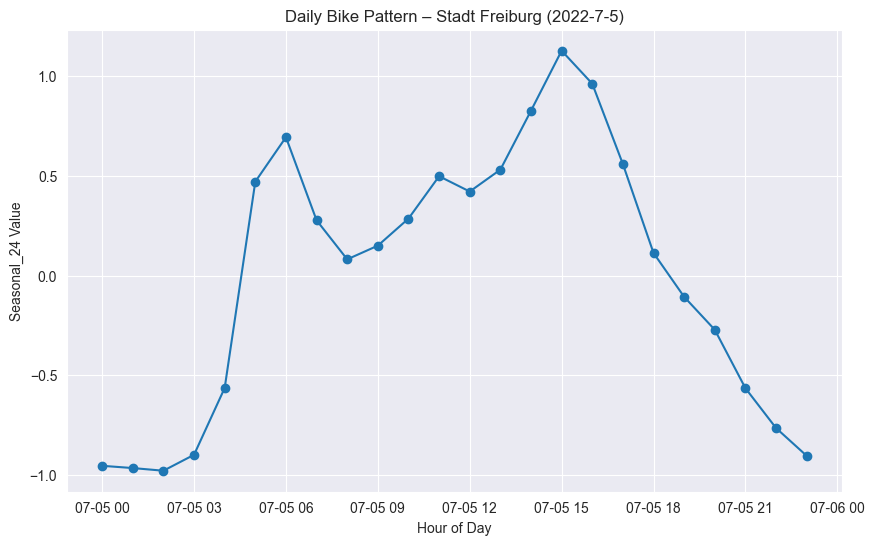

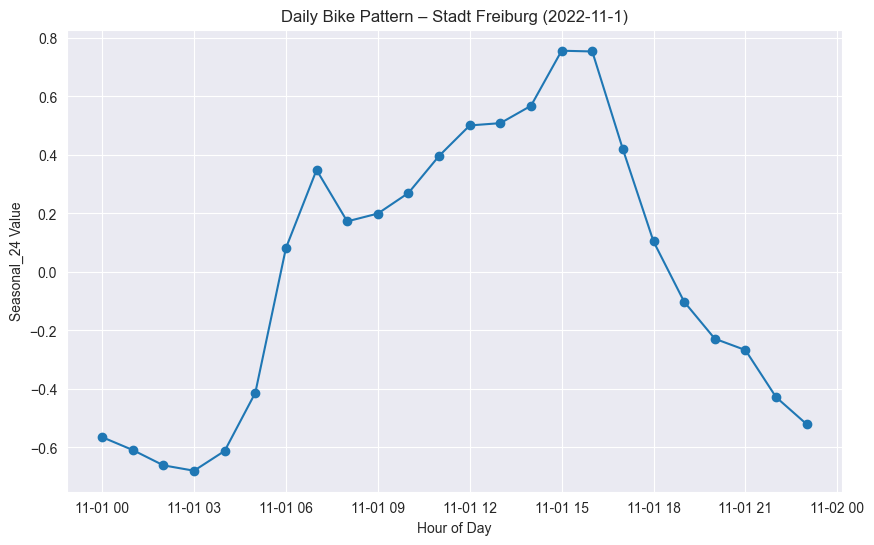

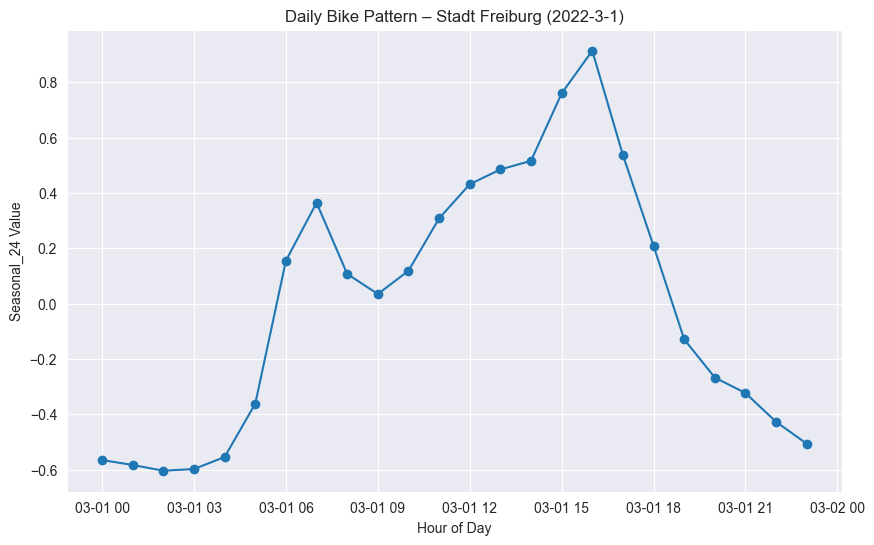

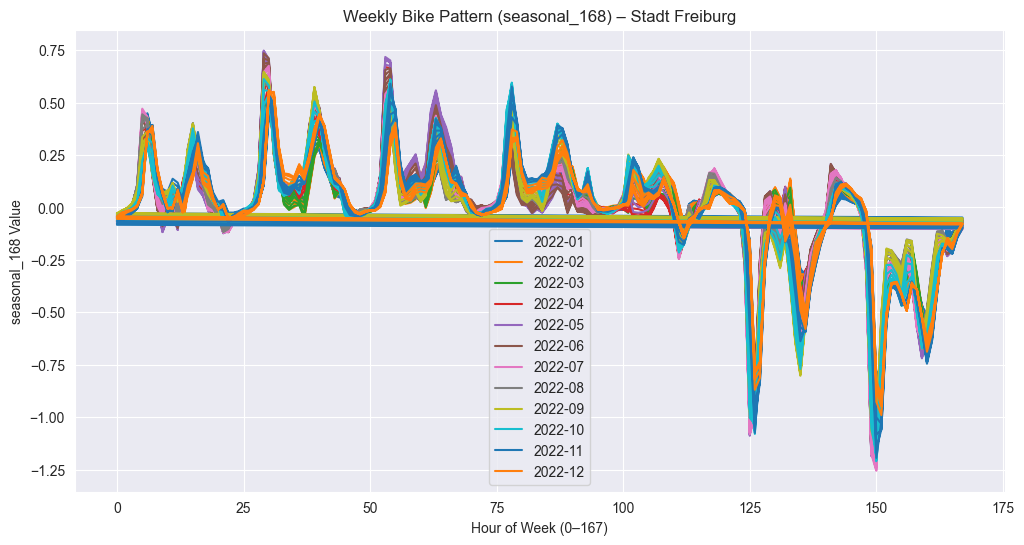

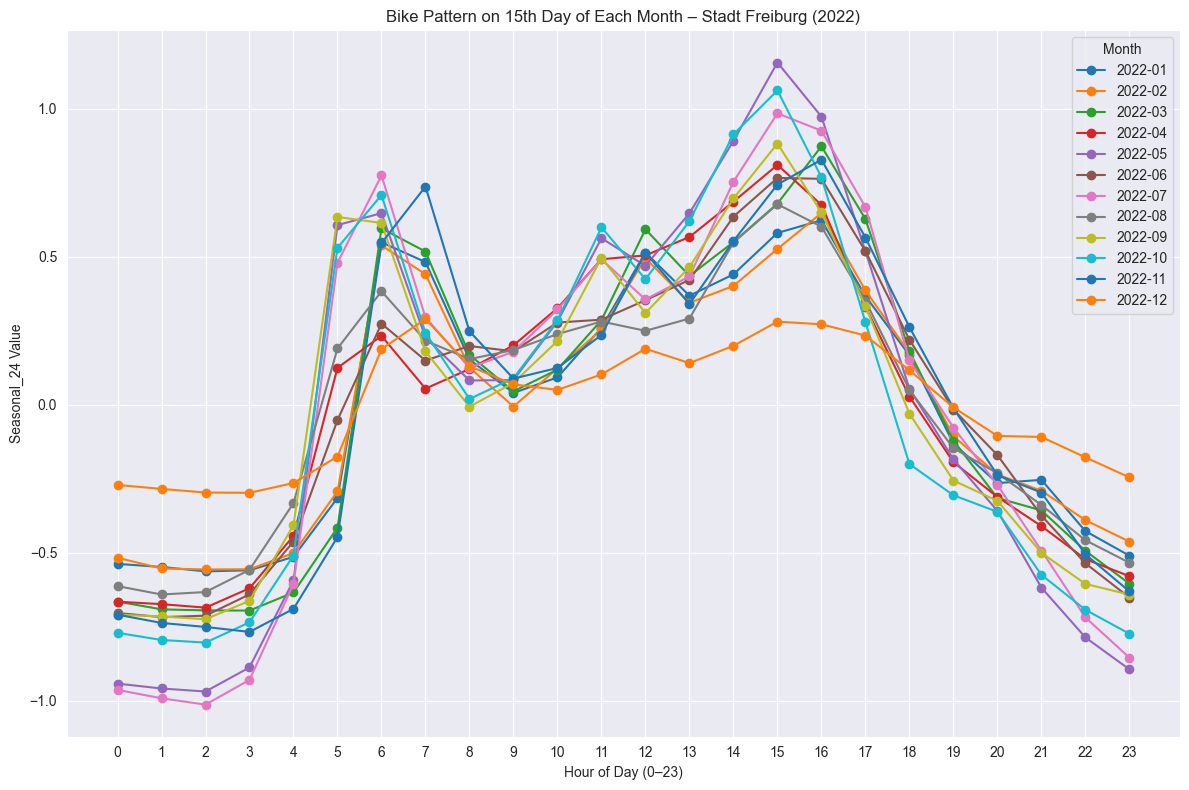

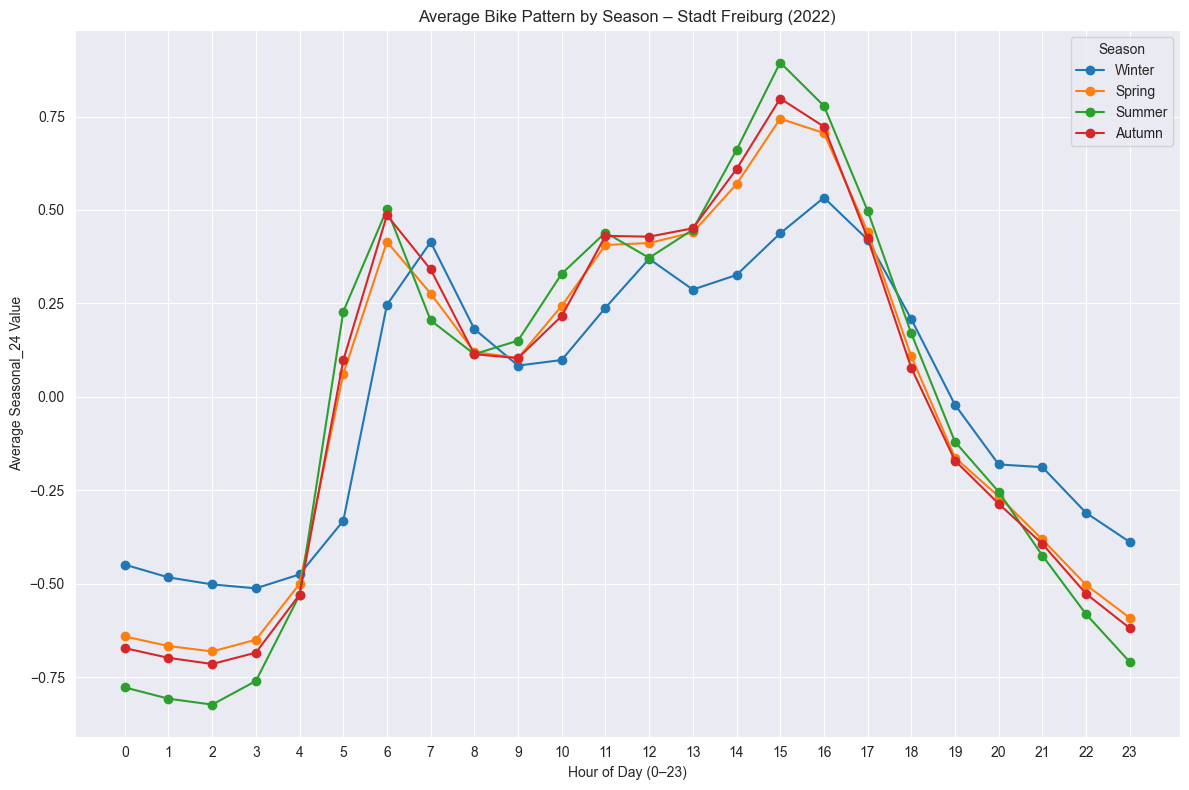

In [13]:
d_res = pd.read_csv("../../data/old_data/mstl_results/res_Stadt Freiburg.csv")
d_res["timestamp"] = pd.to_datetime(d_res["timestamp"], utc=True)
day = 5
year = 2022
month = 7
# Filter the rows where the timestamp corresponds to the specific day
filtered_data = d_res[
    (d_res["timestamp"].dt.year == year) &
    (d_res["timestamp"].dt.month == month) &
    (d_res["timestamp"].dt.day == day)
    ].copy()
filtered_data = filtered_data[['timestamp', 'seasonal_24']]

plt.figure(figsize=(10, 6))
plt.plot(filtered_data["timestamp"], filtered_data["seasonal_24"], marker='o')
plt.title(f"Daily Bike Pattern – Stadt Freiburg ({year}-{month}-{day})")
plt.xlabel("Hour of Day")
plt.ylabel("Seasonal_24 Value")
plt.grid(True)
plt.show()

day = 1
year = 2022
month = 11
# Filter the rows where the timestamp corresponds to the specific day
filtered_data = d_res[
    (d_res["timestamp"].dt.year == year) &
    (d_res["timestamp"].dt.month == month) &
    (d_res["timestamp"].dt.day == day)
    ].copy()
filtered_data = filtered_data[['timestamp', 'seasonal_24']]

plt.figure(figsize=(10, 6))
plt.plot(filtered_data["timestamp"], filtered_data["seasonal_24"], marker='o')
plt.title(f"Daily Bike Pattern – Stadt Freiburg ({year}-{month}-{day})")
plt.xlabel("Hour of Day")
plt.ylabel("Seasonal_24 Value")
plt.grid(True)
plt.show()

day = 1
year = 2022
month = 3
# Filter the rows where the timestamp corresponds to the specific day
filtered_data = d_res[
    (d_res["timestamp"].dt.year == year) &
    (d_res["timestamp"].dt.month == month) &
    (d_res["timestamp"].dt.day == day)
    ].copy()
filtered_data = filtered_data[['timestamp', 'seasonal_24']]

plt.figure(figsize=(10, 6))
plt.plot(filtered_data["timestamp"], filtered_data["seasonal_24"], marker='o')
plt.title(f"Daily Bike Pattern – Stadt Freiburg ({year}-{month}-{day})")
plt.xlabel("Hour of Day")
plt.ylabel("Seasonal_24 Value")
plt.grid(True)
plt.show()

# Months you want to compare
months = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
year = 2022

plt.figure(figsize=(12, 6))

for month in months:
    # Filter that month
    df = d_res[
        (d_res["timestamp"].dt.year == year) &
        (d_res["timestamp"].dt.month == month)
        ].copy()

    # Keep only needed columns
    df = df[["timestamp", "seasonal_168"]]

    # Extract hour within the weekly cycle 0–167
    df["hour_of_week"] = (
            df["timestamp"].dt.dayofweek * 24 +
            df["timestamp"].dt.hour
    )

    # Plot
    plt.plot(df["hour_of_week"], df["seasonal_168"], label=f"{year}-{month:02d}")

plt.title("Weekly Bike Pattern (seasonal_168) – Stadt Freiburg")
plt.xlabel("Hour of Week (0–167)")
plt.ylabel("seasonal_168 Value")
plt.grid(True)
plt.legend()
plt.show()

# Months to compare
months = range(1, 13)
year = 2022
day = 15

# Create the figure
plt.figure(figsize=(12, 8))

# Loop through each month
for month in months:
    # Filter the data for the 15th day of each month
    filtered_data = d_res[
        (d_res["timestamp"].dt.year == year) &
        (d_res["timestamp"].dt.month == month) &
        (d_res["timestamp"].dt.day == day)
        ].copy()

    # Keep only the necessary columns
    filtered_data = filtered_data[['timestamp', 'seasonal_24']]

    # Extract hour of day (0–23)
    filtered_data["hour_of_day"] = filtered_data["timestamp"].dt.hour

    # Plot the data with hour_of_day on the x-axis
    plt.plot(filtered_data["hour_of_day"], filtered_data["seasonal_24"], marker='o', label=f"{year}-{month:02d}")

# Add title and labels
plt.title(f"Bike Pattern on 15th Day of Each Month – Stadt Freiburg ({year})")
plt.xlabel("Hour of Day (0–23)")
plt.ylabel("Seasonal_24 Value")
plt.grid(True)
plt.legend(title="Month")
plt.xticks(range(24))  # Show every hour on the x-axis (0–23)
plt.tight_layout()
plt.show()

# Define the seasons
seasons = {
    'Winter': [12, 1, 2],  # December, January, February
    'Spring': [3, 4, 5],  # March, April, May
    'Summer': [6, 7, 8],  # June, July, August
    'Autumn': [9, 10, 11]  # September, October, November
}

# Create the figure
plt.figure(figsize=(12, 8))

# Loop through each season
for season, months in seasons.items():
    # Filter the data for the specified months in the season
    season_data = d_res[d_res["timestamp"].dt.month.isin(months)].copy()

    # Keep only necessary columns
    season_data = season_data[['timestamp', 'seasonal_24']]

    # Extract hour of day (0–23)
    season_data["hour_of_day"] = season_data["timestamp"].dt.hour

    # Group by hour_of_day and calculate the average seasonal_24 value for each hour
    avg_season_data = season_data.groupby("hour_of_day")["seasonal_24"].mean()

    # Plot the average seasonal_24 values for each season
    plt.plot(avg_season_data.index, avg_season_data.values, label=season, marker='o')

# Add title and labels
plt.title("Average Bike Pattern by Season – Stadt Freiburg (2022)")
plt.xlabel("Hour of Day (0–23)")
plt.ylabel("Average Seasonal_24 Value")
plt.grid(True)
plt.legend(title="Season")
plt.xticks(range(24))  # Show every hour on the x-axis (0–23)
plt.tight_layout()
plt.show()

### Data without MSTL residuals

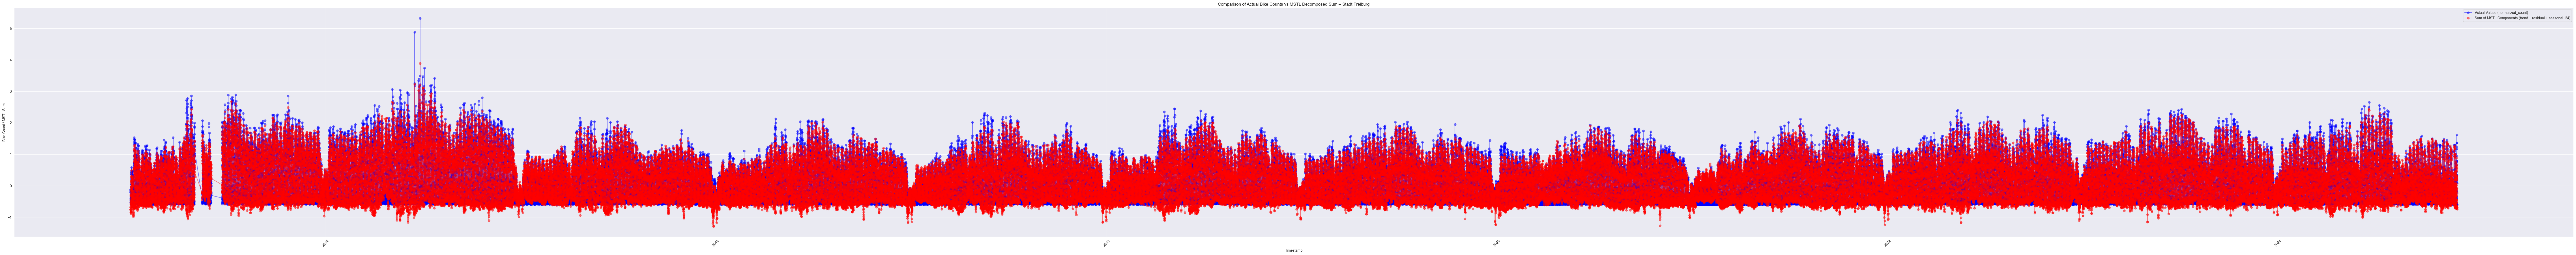

In [14]:
actual_data = pd.read_csv("../../data/old_data/combined_data.csv")
actual_data["timestamp"] = pd.to_datetime(actual_data["timestamp"], utc=True)

# Load the MSTL results (res_Stadt Freiburg.csv)
mstl_data = pd.read_csv("../../data/old_data/mstl_results/res_Stadt Freiburg.csv")
mstl_data["timestamp"] = pd.to_datetime(mstl_data["timestamp"], utc=True)

# Filter for 'Stadt Freiburg' city and make sure we have matching timestamps
actual_data_freiburg = actual_data[actual_data['city'] == 'Stadt Freiburg']
mstl_data_freiburg = mstl_data[mstl_data['city'] == 'Stadt Freiburg']

# Merge both datasets based on the timestamp
merged_data = pd.merge(actual_data_freiburg, mstl_data_freiburg, on="timestamp", how="inner")

# Calculate the sum of MSTL components (trend + residual + seasonal_24)
merged_data['mstl_sum'] = merged_data['trend'] + merged_data['seasonal_24'] + merged_data['seasonal_168'] + merged_data[
    'seasonal_8766']

# Plot the actual values vs the sum of MSTL components
plt.figure(figsize=(100, 10))

# Plot actual normalized_count
plt.plot(merged_data["timestamp"], merged_data["normalized_count"], label="Actual Values (normalized_count)",
         marker='o', linestyle='-', color='blue', alpha=0.5)

# Plot the sum of MSTL components
plt.plot(merged_data["timestamp"], merged_data["mstl_sum"],
         label="Sum of MSTL Components (trend + residual + seasonal_24)", marker='o', linestyle='-', color='red',
         alpha=0.5)

# Add title and labels
plt.title("Comparison of Actual Bike Counts vs MSTL Decomposed Sum – Stadt Freiburg")
plt.xlabel("Timestamp")
plt.ylabel("Bike Count / MSTL Sum")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Typical daily tendency across cities

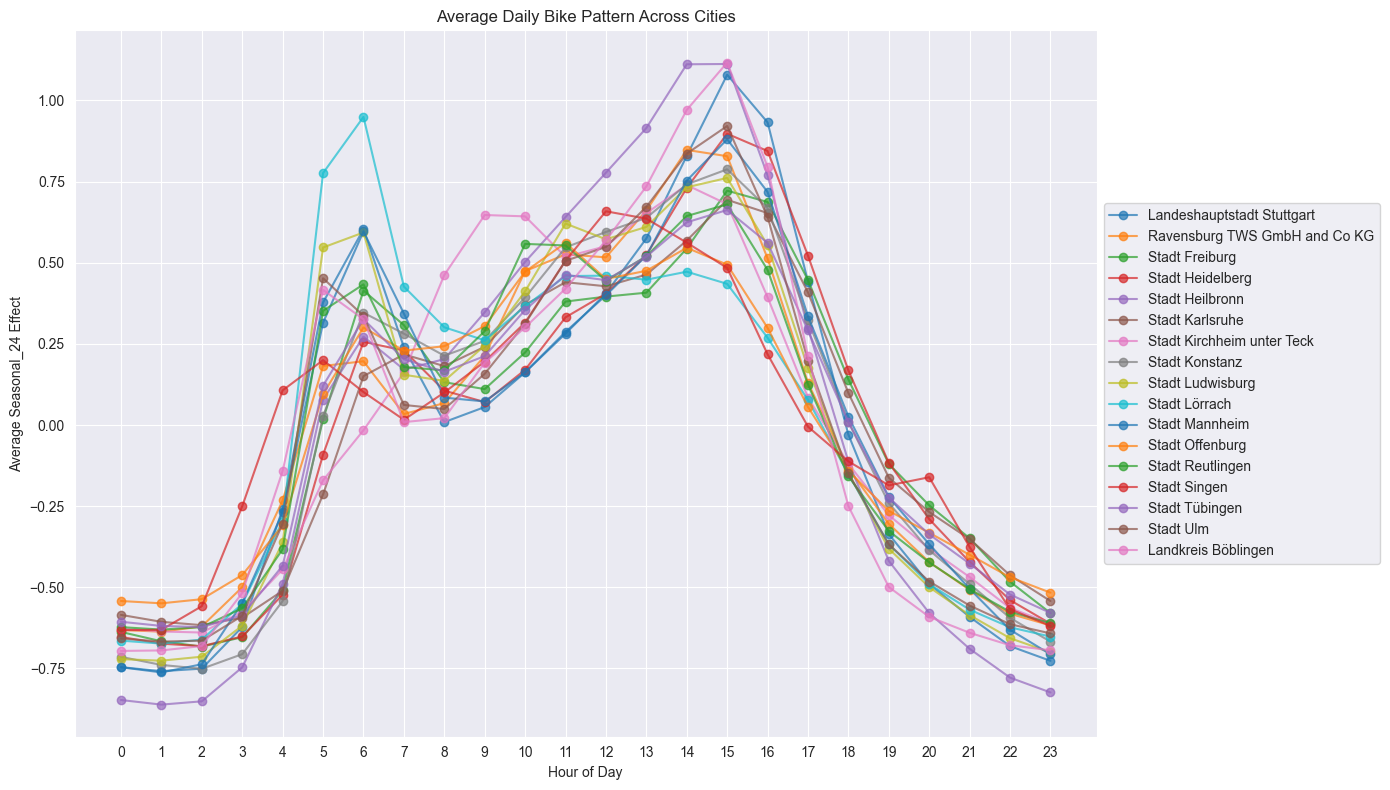

In [15]:
csv_files = [
    "res_Landeshauptstadt Stuttgart.csv",
    "res_Ravensburg TWS GmbH and Co KG.csv",
    "res_Stadt Freiburg.csv",
    "res_Stadt Heidelberg.csv",
    "res_Stadt Heilbronn.csv",
    "res_Stadt Karlsruhe.csv",
    "res_Stadt Kirchheim unter Teck.csv",
    "res_Stadt Konstanz.csv",
    "res_Stadt Ludwisburg.csv",
    "res_Stadt Lörrach.csv",
    "res_Stadt Mannheim.csv",
    "res_Stadt Offenburg.csv",
    "res_Stadt Reutlingen.csv",
    "res_Stadt Singen.csv",
    "res_Stadt Tübingen.csv",
    "res_Stadt Ulm.csv",
    #"res_Stadtverwaltung Aalen.csv"
    "res_Landkreis Böblingen.csv"
    #"res_Landratsamt Rems-Murr-Kreis.csv"
]

plt.figure(figsize=(14, 8))

# Loop through each city file
for file in csv_files:
    city = file.replace("res_", "").replace(".csv", "")  # Extract city name from filename

    # Load CSV
    df = pd.read_csv("../../data/old_data/mstl_results/" + file)
    df["timestamp"] = pd.to_datetime(df["timestamp"], utc=True)

    # Extract the daily seasonal component
    daily_seasonal = df["seasonal_24"]

    # Create a DataFrame with hour of day
    df_daily = pd.DataFrame({
        "hour": df["timestamp"].dt.hour,
        "seasonal_24": daily_seasonal
    })

    # Calculate the average value per hour
    daily_pattern = df_daily.groupby("hour")["seasonal_24"].mean()

    # Plot the city's average daily pattern
    plt.plot(daily_pattern.index, daily_pattern.values, marker='o', label=city, alpha=0.7)

# Finalize the plot
plt.title("Average Daily Bike Pattern Across Cities")
plt.xlabel("Hour of Day")
plt.ylabel("Average Seasonal_24 Effect")
plt.xticks(range(24))
plt.grid(True)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))  # Put legend outside plot
plt.tight_layout()
plt.show()


### Typical weekly pattern across cities

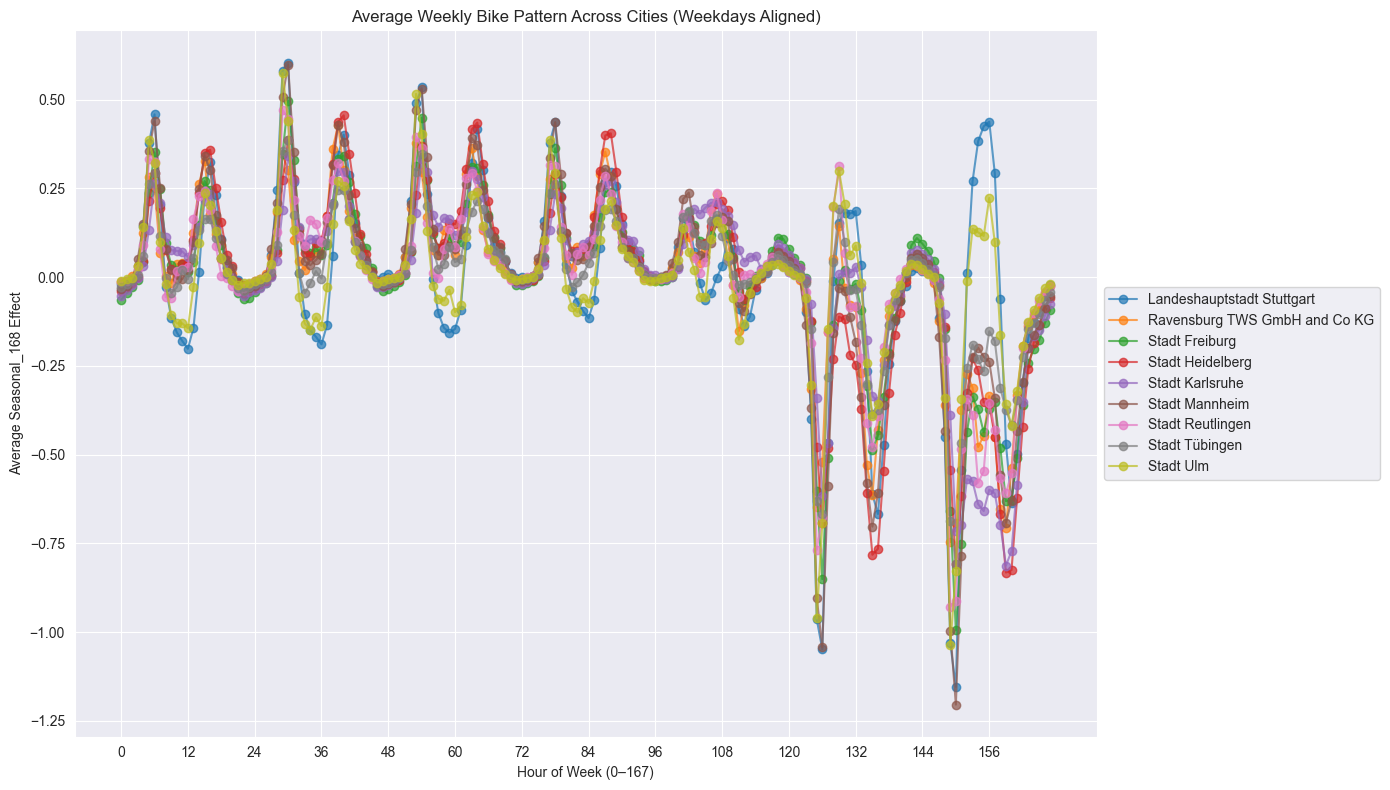

In [18]:
csv_files = [
    "res_Landeshauptstadt Stuttgart.csv",
    "res_Ravensburg TWS GmbH and Co KG.csv",
    "res_Stadt Freiburg.csv",
    "res_Stadt Heidelberg.csv",
    #"res_Stadt Heilbronn.csv",
    "res_Stadt Karlsruhe.csv",
    #"res_Stadt Kirchheim unter Teck.csv",
    #"res_Stadt Konstanz.csv",
    #"res_Stadt Ludwisburg.csv",
    #"res_Stadt Lörrach.csv",
    "res_Stadt Mannheim.csv",
    #"res_Stadt Offenburg.csv",
    "res_Stadt Reutlingen.csv",
    #"res_Stadt Singen.csv",
    "res_Stadt Tübingen.csv",
    "res_Stadt Ulm.csv",
    #"res_Stadtverwaltung Aalen.csv"
]

plt.figure(figsize=(14, 8))

for file in csv_files:
    city = file.replace("res_", "").replace(".csv", "")

    # Load CSV
    df = pd.read_csv("../../data/old_data/mstl_results/"+file)
    df["timestamp"] = pd.to_datetime(df["timestamp"], utc=True)

    # Extract weekly seasonal component
    df_weekly = pd.DataFrame({
        "weekday": df["timestamp"].dt.dayofweek,  # 0=Monday, 6=Sunday
        "hour": df["timestamp"].dt.hour,
        "seasonal_168": df["seasonal_168"]
    })

    # Compute the **average value for each hour of the week**
    weekly_pattern = df_weekly.groupby(["weekday", "hour"])["seasonal_168"].mean().unstack(level=0)

    # Flatten to 0-167 hours
    weekly_pattern_flat = weekly_pattern.values.flatten(order='F')  # Column-major to keep Mon->Sun order

    plt.plot(range(168), weekly_pattern_flat, marker='o', label=city, alpha=0.7)

plt.title("Average Weekly Bike Pattern Across Cities (Weekdays Aligned)")
plt.xlabel("Hour of Week (0–167)")
plt.ylabel("Average Seasonal_168 Effect")
plt.xticks(range(0, 168, 12))
plt.grid(True)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

### Yearly tendency across cities

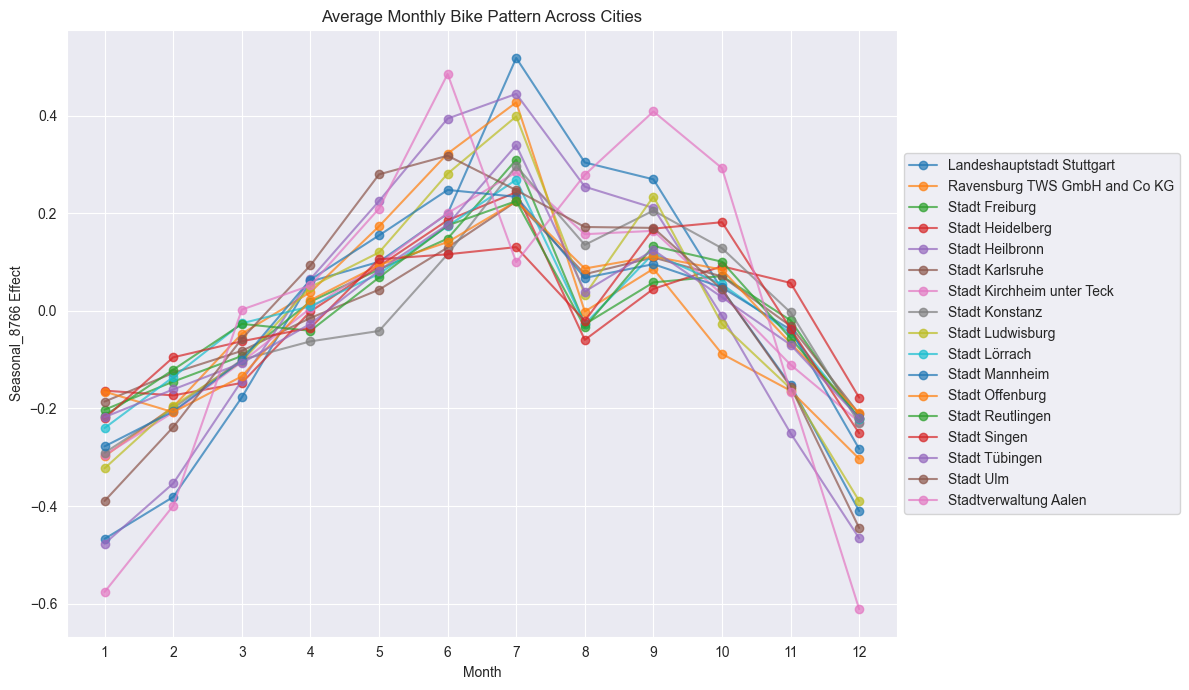

In [19]:
csv_files = [
    "res_Landeshauptstadt Stuttgart.csv",
    "res_Ravensburg TWS GmbH and Co KG.csv",
    "res_Stadt Freiburg.csv",
    "res_Stadt Heidelberg.csv",
    "res_Stadt Heilbronn.csv",
    "res_Stadt Karlsruhe.csv",
    "res_Stadt Kirchheim unter Teck.csv",
    "res_Stadt Konstanz.csv",
    "res_Stadt Ludwisburg.csv",
    "res_Stadt Lörrach.csv",
    "res_Stadt Mannheim.csv",
    "res_Stadt Offenburg.csv",
    "res_Stadt Reutlingen.csv",
    "res_Stadt Singen.csv",
    "res_Stadt Tübingen.csv",
    "res_Stadt Ulm.csv",
    "res_Stadtverwaltung Aalen.csv"
]

plt.figure(figsize=(12, 7))

for file in csv_files:
    city = file.replace("res_", "").replace(".csv", "")

    # Load CSV
    df = pd.read_csv("../../data/old_data/mstl_results/"+file)
    df["timestamp"] = pd.to_datetime(df["timestamp"], utc=True)

    # Extract yearly seasonal component
    df_yearly = pd.DataFrame({
        "month": df["timestamp"].dt.month,
        "seasonal_8766": df["seasonal_8766"]
    })

    # Aggregate by month
    monthly_pattern = df_yearly.groupby("month")["seasonal_8766"].mean()

    # Plot
    plt.plot(range(1, 13), monthly_pattern, marker='o', label=city, alpha=0.7)

plt.title("Average Monthly Bike Pattern Across Cities")
plt.xlabel("Month")
plt.ylabel("Seasonal_8766 Effect")
plt.xticks(range(1, 13))
plt.grid(True)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

### Explained variance by MSTL without Residuals

In [21]:
csv_files = [
    "res_Landeshauptstadt Stuttgart.csv",
    "res_Ravensburg TWS GmbH and Co KG.csv",
    "res_Stadt Freiburg.csv",
    "res_Stadt Heidelberg.csv",
    "res_Stadt Heilbronn.csv",
    "res_Stadt Karlsruhe.csv",
    "res_Stadt Kirchheim unter Teck.csv",
    "res_Stadt Konstanz.csv",
    "res_Stadt Ludwisburg.csv",
    "res_Stadt Lörrach.csv",
    "res_Stadt Mannheim.csv",
    "res_Stadt Offenburg.csv",
    "res_Stadt Reutlingen.csv",
    "res_Stadt Singen.csv",
    "res_Stadt Tübingen.csv",
    "res_Stadt Ulm.csv",
    "res_Stadtverwaltung Aalen.csv"
]

results = []

for file in csv_files:
    city = file.replace("res_", "").replace(".csv", "")

    df = pd.read_csv("../../data/old_data/mstl_results/"+file)

    # Ensure timestamp is datetime (optional for this calculation)
    df["timestamp"] = pd.to_datetime(df["timestamp"], utc=True)

    # Compute variance explained by MSTL
    # observed = trend + seasonal_24 + seasonal_168 + seasonal_8766 + residual
    observed_var = df['trend'].add(df['seasonal_24'], fill_value=0) \
        .add(df['seasonal_168'], fill_value=0) \
        .add(df['seasonal_8766'], fill_value=0) \
        .add(df['residual'], fill_value=0).var()  # just for sanity, should equal df.sum^2 variance

    residual_var = df['residual'].var()

    variance_explained = 1 - residual_var / observed_var

    # Store results
    results.append({
        "City": city,
        "Residual Variance": residual_var,
        "Variance Explained": variance_explained
    })

# Create DataFrame
variance_table = pd.DataFrame(results)

# Sort by variance explained
variance_table = variance_table.sort_values(by="Variance Explained", ascending=False)

print(variance_table)

                             City  Residual Variance  Variance Explained
12               Stadt Reutlingen           0.017419            0.956638
13                   Stadt Singen           0.020218            0.952749
3                Stadt Heidelberg           0.033685            0.945422
2                  Stadt Freiburg           0.029920            0.925435
7                  Stadt Konstanz           0.057964            0.924850
10                 Stadt Mannheim           0.055234            0.922358
11                Stadt Offenburg           0.052891            0.917608
14                 Stadt Tübingen           0.034945            0.909317
8                Stadt Ludwisburg           0.088175            0.908191
15                      Stadt Ulm           0.061770            0.904109
5                 Stadt Karlsruhe           0.034597            0.902963
4                 Stadt Heilbronn           0.181348            0.896696
1   Ravensburg TWS GmbH and Co KG           0.05923

### Plot residuals vs rest

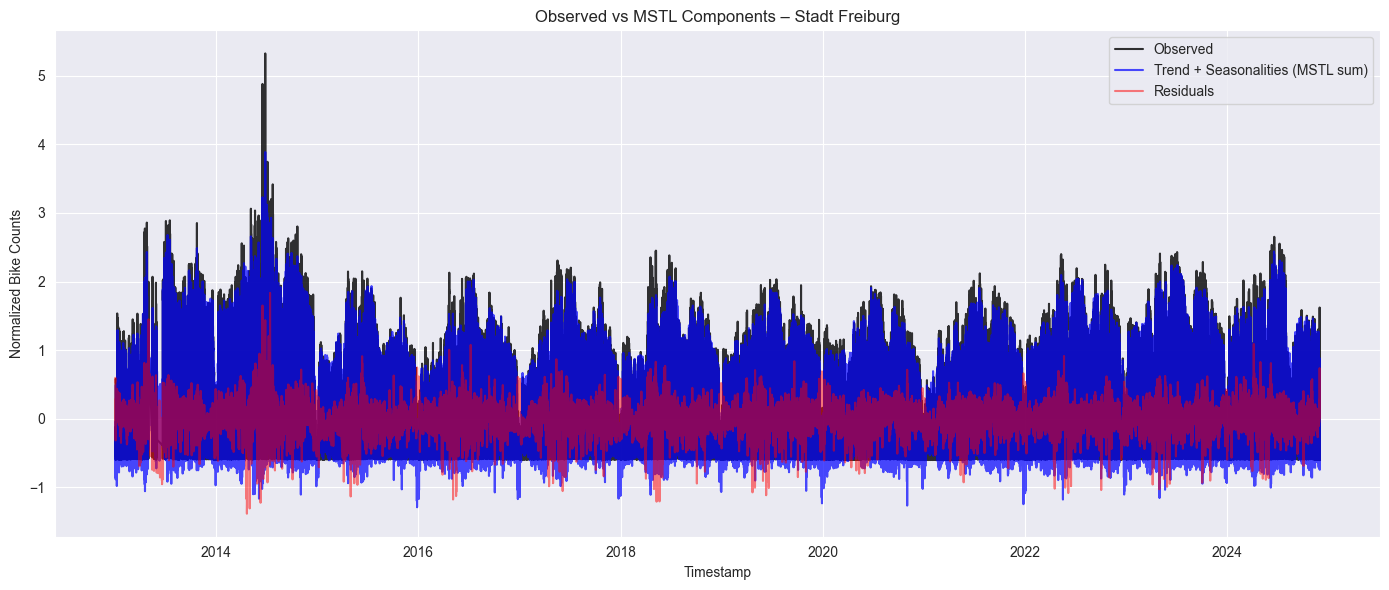

In [23]:
file = "../../data/old_data/mstl_results/res_Stadt Freiburg.csv"
df = pd.read_csv(file)
df["timestamp"] = pd.to_datetime(df["timestamp"], utc=True)

# Compute the MSTL sum (without residual)
mstl_sum = df['trend'] + df['seasonal_24'] + df['seasonal_168'] + df['seasonal_8766']

plt.figure(figsize=(14, 6))

# Plot observed values
plt.plot(df['timestamp'], mstl_sum + df['residual'], label="Observed", color='black', alpha=0.8)

# Plot MSTL sum
plt.plot(df['timestamp'], mstl_sum, label="Trend + Seasonalities (MSTL sum)", color='blue', alpha=0.7)

# Plot residuals (shifted for visibility)
plt.plot(df['timestamp'], df['residual'], label="Residuals", color='red', alpha=0.5)

plt.title("Observed vs MSTL Components – Stadt Freiburg")
plt.xlabel("Timestamp")
plt.ylabel("Normalized Bike Counts")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Try linear regression on the residuals (purely explorative)

                       timestamp  residual            city temp_category  \
0      2013-01-01 00:00:00+00:00  0.537763  Stadt Freiburg          cold   
1      2013-01-01 01:00:00+00:00  0.597261  Stadt Freiburg          cold   
2      2013-01-01 02:00:00+00:00  0.559416  Stadt Freiburg          cold   
3      2013-01-01 03:00:00+00:00  0.492151  Stadt Freiburg          cold   
4      2013-01-01 04:00:00+00:00  0.425914  Stadt Freiburg          cold   
...                          ...       ...             ...           ...   
104446 2024-11-30 22:00:00+00:00  0.304757  Stadt Freiburg          cold   
104447 2024-11-30 23:00:00+00:00  0.213297  Stadt Freiburg          cold   
104448 2024-12-01 00:00:00+00:00  0.084361  Stadt Freiburg          cold   
104449 2024-12-01 01:00:00+00:00  0.100008  Stadt Freiburg          cold   
104450 2024-12-01 02:00:00+00:00  0.141466  Stadt Freiburg          cold   

       rain_category snow_category  extreme_heat  freezing  
0            no_rain      

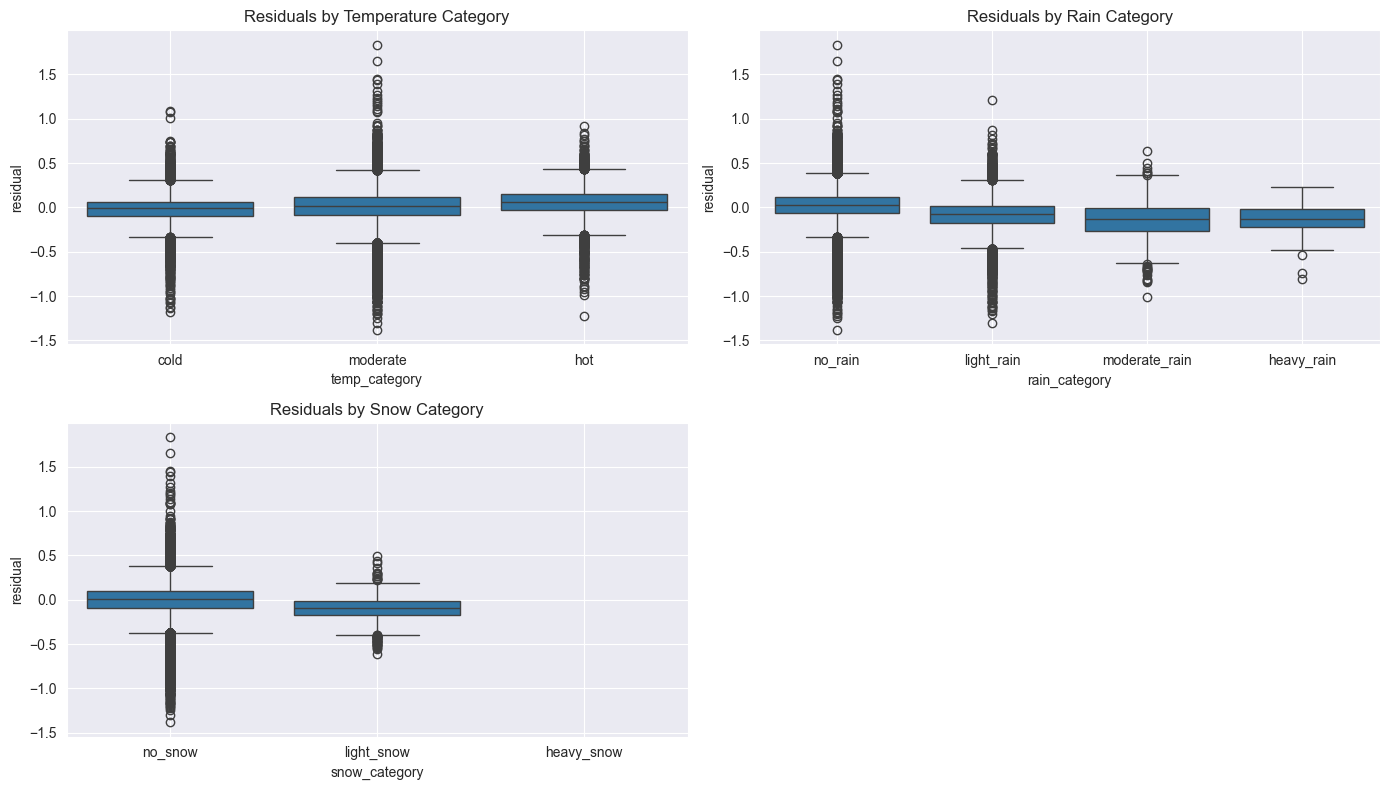

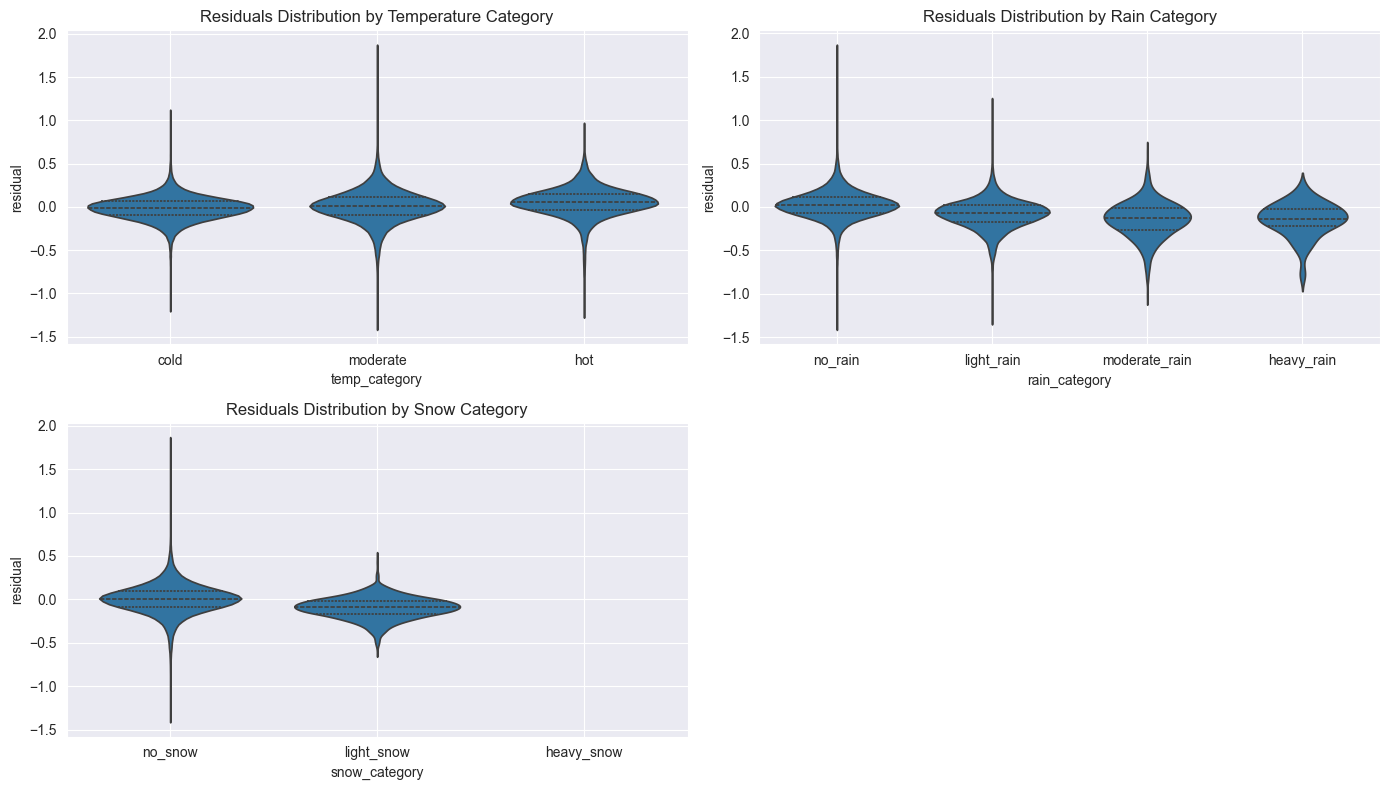

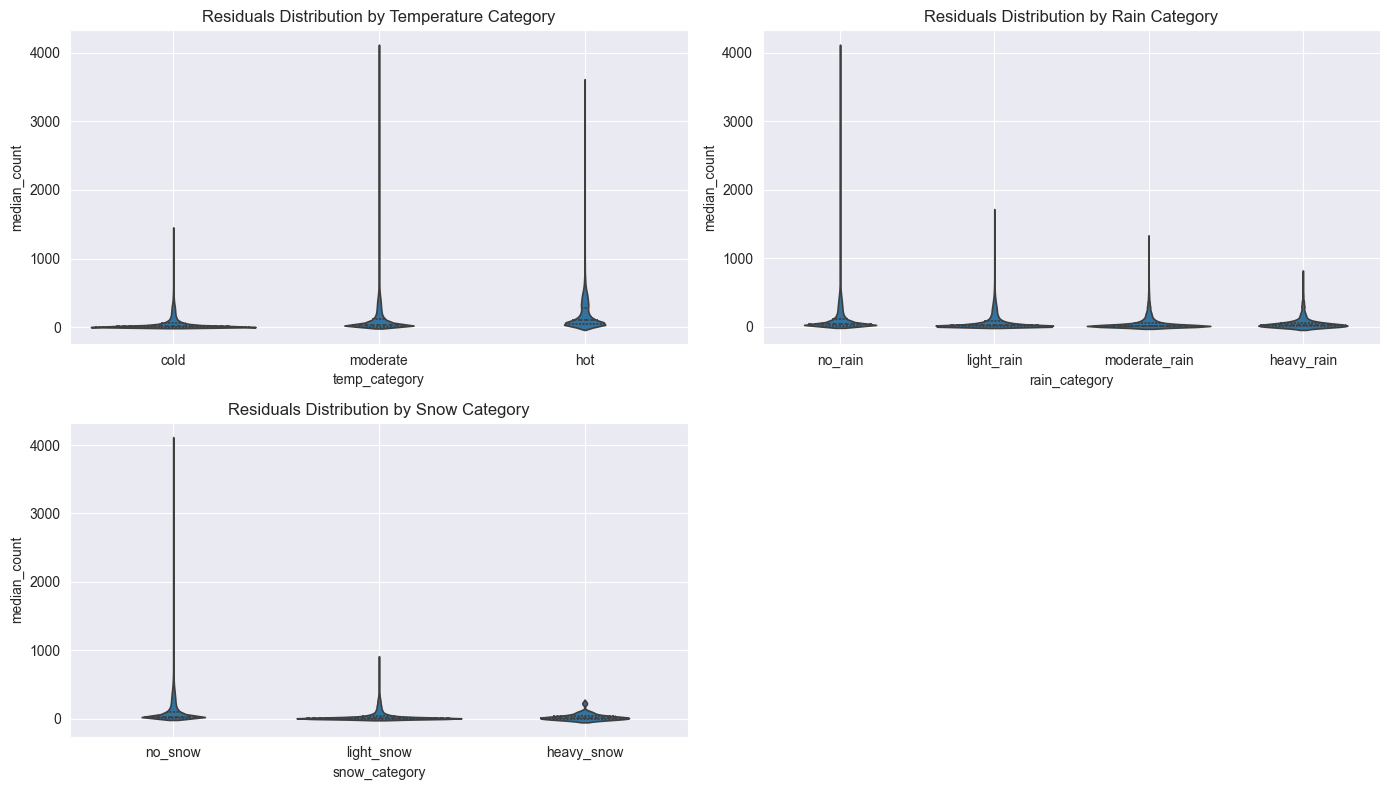

In [27]:
csv_files = [
    #"res_Landeshauptstadt Stuttgart.csv",
    #"res_Ravensburg TWS GmbH and Co KG.csv",
    "res_Stadt Freiburg.csv",
    #"res_Stadt Heidelberg.csv",
    #"res_Stadt Heilbronn.csv",
    #"res_Stadt Karlsruhe.csv",
    #"res_Stadt Kirchheim unter Teck.csv",
    #"res_Stadt Konstanz.csv",
    #"res_Stadt Ludwisburg.csv",
    #"res_Stadt Lörrach.csv",
    #"res_Stadt Mannheim.csv",
    #"res_Stadt Offenburg.csv",
    #"res_Stadt Reutlingen.csv",
    #"res_Stadt Singen.csv",
    #"res_Stadt Tübingen.csv",
    #"res_Stadt Ulm.csv",
    #"res_Stadtverwaltung Aalen.csv"
]

# Path to weather data
weather_df = pd.read_csv("../../data/old_data/weather_data.csv")
weather_df.rename(columns={'date': 'timestamp'}, inplace=True)
weather_df['timestamp'] = pd.to_datetime(weather_df['timestamp'], utc=True)

# Prepare a container for merged results
merged_results = pd.DataFrame()
for file in csv_files:
    city = file.replace("res_", "").replace(".csv", "").strip()

    # Load MSTL
    df = pd.read_csv("../../data/old_data/mstl_results/"+file)
    df['timestamp'] = pd.to_datetime(df['timestamp'], utc=True)
    city_weather = weather_df[weather_df['city'] == city].copy()

    # Merge
    merged = pd.merge(df, city_weather, left_on=['timestamp', 'city'], right_on=['timestamp', 'city'], how='left')

    # Temperature categories
    merged['temp_category'] = pd.cut(
        merged['apparent_temperature'],
        bins=[-float('inf'), 5, 25, float('inf')],
        labels=['cold', 'moderate', 'hot']
    )

    # Rain categories
    merged['rain_category'] = pd.cut(
        merged['rain'],
        bins=[-0.01, 0, 2, 5, float('inf')],
        labels=['no_rain', 'light_rain', 'moderate_rain', 'heavy_rain']
    )

    # Snow categories
    merged['snow_category'] = pd.cut(
        merged['snowfall'],
        bins=[-0.01, 0, 2, float('inf')],
        labels=['no_snow', 'light_snow', 'heavy_snow']
    )

    # Extreme heat / freezing flags
    merged['extreme_heat'] = merged['apparent_temperature'] > 35
    merged['freezing'] = merged['apparent_temperature'] < 0

    # Store merged city data
    merged.drop(
        columns=['trend', 'seasonal_24', 'seasonal_168', 'seasonal_8766', 'apparent_temperature', 'temperature_2m',
                 'rain', 'snowfall'], inplace=True)
    merged_results = pd.concat([merged_results, merged], ignore_index=True)

print(merged_results)

plt.figure(figsize=(14, 8))

# Box plot for residuals vs temperature category
plt.subplot(2, 2, 1)
sns.boxplot(data=merged_results, x='temp_category', y='residual')
plt.title("Residuals by Temperature Category")
plt.grid(True)

# Box plot for residuals vs rain category
plt.subplot(2, 2, 2)
sns.boxplot(data=merged_results, x='rain_category', y='residual')
plt.title("Residuals by Rain Category")
plt.grid(True)

# Box plot for residuals vs snow category
plt.subplot(2, 2, 3)
sns.boxplot(data=merged_results, x='snow_category', y='residual')
plt.title("Residuals by Snow Category")
plt.grid(True)

plt.tight_layout()
plt.show()
# Violin plot for residuals vs temperature category
plt.figure(figsize=(14, 8))

plt.subplot(2, 2, 1)
sns.violinplot(data=merged_results, x='temp_category', y='residual', inner="quart")
plt.title("Residuals Distribution by Temperature Category")
plt.grid(True)

# Violin plot for residuals vs rain category
plt.subplot(2, 2, 2)
sns.violinplot(data=merged_results, x='rain_category', y='residual', inner="quart")
plt.title("Residuals Distribution by Rain Category")
plt.grid(True)

# Violin plot for residuals vs snow category
plt.subplot(2, 2, 3)
sns.violinplot(data=merged_results, x='snow_category', y='residual', inner="quart")
plt.title("Residuals Distribution by Snow Category")
plt.grid(True)

plt.tight_layout()
plt.show()

temp_d = d.copy()
temp_d['temp_category'] = pd.cut(
    temp_d['apparent_temperature'],
    bins=[-float('inf'), 5, 25, float('inf')],
    labels=['cold', 'moderate', 'hot']
)

# Rain categories
temp_d['rain_category'] = pd.cut(
    temp_d['rain'],
    bins=[-0.01, 0, 2, 5, float('inf')],
    labels=['no_rain', 'light_rain', 'moderate_rain', 'heavy_rain']
)

# Snow categories
temp_d['snow_category'] = pd.cut(
    temp_d['snowfall'],
    bins=[-0.01, 0, 2, float('inf')],
    labels=['no_snow', 'light_snow', 'heavy_snow']
)

# Extreme heat / freezing flags
temp_d['extreme_heat'] = temp_d['apparent_temperature'] > 35
temp_d['freezing'] = temp_d['apparent_temperature'] < 0
# Violin plot for residuals vs temperature category
plt.figure(figsize=(14, 8))

plt.subplot(2, 2, 1)
sns.violinplot(data=temp_d, x='temp_category', y='median_count', inner="quart")
plt.title("Residuals Distribution by Temperature Category")
plt.grid(True)

# Violin plot for residuals vs rain category
plt.subplot(2, 2, 2)
sns.violinplot(data=temp_d, x='rain_category', y='median_count', inner="quart")
plt.title("Residuals Distribution by Rain Category")
plt.grid(True)

# Violin plot for residuals vs snow category
plt.subplot(2, 2, 3)
sns.violinplot(data=temp_d, x='snow_category', y='median_count', inner="quart")
plt.title("Residuals Distribution by Snow Category")
plt.grid(True)

plt.tight_layout()
plt.show()

### Compare different versions of MSTL and preprocessing

In [ ]:
city = "Stadt Freiburg"
periods = [24, 168, 8766]
res = performMSTL(d, city, on_column="median_count", use_boxcox=True, lambda_bc=0, periods=periods)
plotMSTLResults(res, city)

In [ ]:
city = "Stadt Freiburg"
periods = [24, 168, 8766]
res2 = performMSTL(d, city, on_column="median_count", use_boxcox=True, periods=periods)
plotMSTLResults(res2, city)

In [ ]:
city = "Stadt Freiburg"
periods = [24, 168, 8766]
res3 = performMSTL(d, city, on_column="median_count", use_boxcox=False, periods=periods)
plotMSTLResults(res3, city)

### Try iterative STL instead of MSTL

In [ ]:
seasonal_components = {}
periods = [24, 168, 8766]

for p in sorted(periods):
    stl = STL(
        residual,
        period=p,
        seasonal=p+1,   # common choice: seasonal window ≈ period
        trend=2*p +1,      # effectively disables trend estimation
        robust=True
    )

    res = stl.fit()
    seasonal = res.seasonal

    seasonal_components[p] = seasonal

    # remove this seasonality before next iteration
    residual = residual - seasonal
    print("finished:",p)

remainder = residual
